#### Why we need `data-independent` virtual samples?

One of the annoying things we have encountered so far is that the virtual samples we obtained via eigendecomposition for Bayesian kernel regression is `data-dependent`

That is, the virtual samples we get can only approximate the covariance structure over the data points that generate these virtual samples, which can lead to two problems

* As shown previously, we have to `correct the prediction variance` in the end, as the covariance structure among testing data points is involved in the computation of prediction variance and our virtual samples cannot properly account for it. Unfortunately, we only know this because we know the `analytical solution`. For the problems that may not have analytical solution, we would get the wrong answers without even knowing it
* Of course, if we could generate virtual samples from the kernel matrix over the entire input space (all training and testing points), then the covariance structure among all data points would be properly accounted for. However, this is very inefficient computationally, even if it is not infeasible

#### Random Fourier features

We now explore the use of random Fourier features (`notes_08`) to tackle this issue

Recall RFFs come from Bochner's theorem that allows to rewrite RBF kernel function as

$$\begin{align*}
k(x, y) &=\exp\left(-\frac{(x-y)^2}{2\sigma_k^2}\right)\\
&\approx \frac{1}{m}\sum_{i=1}^m\left[\sqrt{2}\cos(\omega_i^Tx+b_i)\right]\left[\sqrt{2}\cos(\omega_i^Ty+b_i)\right] \\
&=\begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_1^Tx+b_1) &\cdots &\sqrt{\frac{2}{m}}\cos(\omega_m^Tx+b_m)\end{bmatrix}\begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_1^Ty+b_1) \\ \vdots \\\sqrt{\frac{2}{m}}\cos(\omega_m^Ty+b_m)\end{bmatrix} \\
&=\phi(x)^T\phi(y)
\end{align*}$$

where

* $\omega_i$ follows `Gaussian distribution` $N(0, \frac{1}{\sigma_k}I)$ (vector or scalar)
* $b_i$ follows `uniform distribution` over $(0, 2\pi)$ (scalar)
* $m$ is a parameter indicating the number of RFFs to construct $\phi(\cdot)$

If we have $n$ data points $x_1, \cdots, x_n\in\mathbf{R}^d$, then, their RFFs can be expressed compactly as

$$\begin{align*}
\phi(x)=\begin{bmatrix}\phi(x_1)^T \\ \vdots \\ \phi(x_n)^T\end{bmatrix}
&= \begin{bmatrix}\begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_{1}^Tx_1+b_1) &\cdots &\sqrt{\frac{2}{m}}\cos(\omega_{m}^Tx_1+b_m)\end{bmatrix} \\ \vdots \\ \begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_{1}^Tx_n+b_1) &\cdots &\sqrt{\frac{2}{m}}\cos(\omega_{m}^Tx_n+b_m)\end{bmatrix}\end{bmatrix} \\
&=\sqrt{\frac{2}{m}}\cos \left(\begin{bmatrix}\begin{bmatrix}(\omega_{1}^Tx_1+b_1) &\cdots &(\omega_{m}^Tx_1+b_m)\end{bmatrix} \\ \vdots \\ \begin{bmatrix}(\omega_{1}^Tx_n+b_1) &\cdots &(\omega_{m}^Tx_n+b_m)\end{bmatrix}\end{bmatrix}\right)\\
&=\sqrt{\frac{2}{m}}\cos  \left(\begin{bmatrix}x_1^T \\ \vdots \\x_n^T\end{bmatrix}_{n \times d}\begin{bmatrix}\omega_1 & \cdots &\omega_m\end{bmatrix}_{d \times m}+\begin{bmatrix}b_1 & \cdots &b_m \end{bmatrix}_{1 \times m}\right)
\end{align*}$$

From this formulation, we see that for any $x_i$, its RFFs do not depend on any other data points, making RFFs `data-independent`

#### Bayesian kernel regression via RFFs (no correction step needed)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

In [ ]:
class BayesianKernelRegression:
    def __init__(
        self,
        num_points=30,
        num_x_test=200,
        num_rff_features=100,
        num_mc=10,
        metropolis_step_size=1e-4,
        num_samples_metropolis=300,
        burn_in=100,
        num_gd_iter= 10000,
        debug=False,
        random_seed=42
        ):
        np.random.seed(random_seed)

        self.debug = debug # Toggle printing stuff
        self.num_features = num_rff_features  # Number of random Fourier features

        # Initialize parameters as class attributes
        self.num_points = num_points # Original data points
        self.num_x_test = num_x_test # Number of x_test
        self.sigma_d_true = 0.1 # True standard deviation of noise in measured y, only used in generating data
        self.sigma_d = 0.1 # Guessed standard deviation of noise in measured y, only used in model
        self.sigma_k = 0.9 # Kernel
        self.sigma_theta = 0.5 # Prior of theta
        self.learning_rate = 0.00001
        self.iterations = num_gd_iter
        self.num_samples_metropolis = num_samples_metropolis # For Metropolis
        self.step_size = metropolis_step_size
        self.threshold = 1e-10 # For removing small eigenvectors
        self.num_samples_mc = num_mc # Number of samples in MC approximation of Bayesian marginalization, for each theta at each x_test
        self.burn_in = burn_in

        self.x_l = 0 # Lower end of x
        self.x_h = 6 * np.pi # Higher end of x

        # Data
        self.x = np.random.uniform(self.x_l, self.x_h, self.num_points)
        self.y = self.create_function(self.x)

        # x_test
        self.x_test = np.linspace(self.x.min() - 2, self.x.max() + 2, self.num_x_test)

        # # Generate random Fourier features (1d)
        self.omega = np.random.normal(0, 1/self.sigma_k, (self.num_features, 1))
        self.b = np.random.uniform(0, 2 * np.pi, (1, self.num_features))

    # Create function
    def create_function(self, x, noiseless=False):
        y = np.sin(x)  # True underlying function
        if not noiseless:
            y += np.random.normal(0, self.sigma_d_true, size=x.shape)
        return y

    # Transform inputs into random Fourier features
    def transform_features(self, x):
        projection = x.reshape(-1, 1) @ self.omega.T + self.b
        return np.sqrt(2.0 / self.num_features) * np.cos(projection)

    # Generate virtual samples using random Fourier features for training data
    def generate_virtual_samples_train(self):
        self.v_samples_train = self.transform_features(self.x)
        if self.debug:
            print(f'v_samples_train shape: {self.v_samples_train.shape}')
            print(f'v_samples_train condition number: {np.linalg.cond(self.v_samples_train)}')
            print()

    # Generate virtual samples using random Fourier features for test data
    def generate_virtual_samples_test(self):
        self.v_samples_test = self.transform_features(self.x_test)
        if self.debug:
            print(f'v_samples_test shape: {self.v_samples_test.shape}')
            print()

    # Kernel function
    def rbf_kernel_vectorized(self, x_set_1, x_set_2):
        diff = x_set_1[:, None, :] - x_set_2[None, :, :]
        l2 = np.sum((diff / self.sigma_k) ** 2, axis=2)
        k_mat = np.exp(-0.5 * l2)

        return k_mat

    # Gradient descent method, MAP or ML
    def gradient_descent(self):
        theta = np.zeros(self.v_samples_train.shape[1])
        for k in range(self.iterations):
            y_pred = self.v_samples_train @ theta
            prior_theta = np.mean(theta**2) / self.sigma_theta**2
            likelihood = np.mean((y_pred - self.y)**2) / self.sigma_d**2
            loss = prior_theta + likelihood

            grad_prior_theta = theta / self.sigma_theta**2
            grad_likelihood = self.v_samples_train.T @ (y_pred - self.y) / self.sigma_d**2
            grad_loss = grad_prior_theta + grad_likelihood
            theta -= self.learning_rate * grad_loss

            if self.debug and k % (self.iterations // 10) == 0:
                print(f"Iteration {k}: loss = {loss:.4f}")

        # if self.debug:
        #     print(f"MAP estimate of parameters: {theta[:10]}")
        #     print()
        return theta

    # Method to compute probability to evaluate whether to accept new theta in Metroplis
    def posterior(self, theta):
        # Posterior p(theta|D) is proportional to prior p(theta) times likelihood p(D|theta)
        y_pred = self.v_samples_train @ theta
        prior = np.exp(-0.5 * np.sum(theta**2) / self.sigma_theta**2)
        likelihood = np.exp(-0.5 * np.sum((y_pred - self.y)**2) / self.sigma_d**2)
        return prior * likelihood

    # Metropolis
    def metropolis(self, theta_init):
        samples = []
        theta_current = theta_init
        accepted = 0

        # Evaluate probability of current theta
        posterior_current = self.posterior(theta_current)

        # Compute covariance matrix based on step size, to select next theta
        proposal_cov = np.eye(theta_current.shape[0]) * self.step_size

        for i in range(self.num_samples_metropolis + self.burn_in):
            # Get new theta using Gaussian distribution
            theta_proposal = np.random.multivariate_normal(theta_current, proposal_cov)

            # Compute probability of new theta
            posterior_proposal = self.posterior(theta_proposal)

            # Compute ratio between new and current
            acceptance_prob = posterior_proposal / posterior_current

            # Determine acceptance
            if np.random.rand() < acceptance_prob:
                accepted += 1
                theta_current = theta_proposal
                posterior_current = posterior_proposal

            # Add to sample list after burn-in period
            if i >= self.burn_in:
                samples.append(theta_current)

        self.theta_samples = np.array(samples)

        acceptance_rate = accepted / (self.num_samples_metropolis + self.burn_in)
        # print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

        if self.debug:
            print(f'Metropolis samples shape: {self.theta_samples.shape}')
            print(f'Metropolis acceptance Rate: {acceptance_rate:.2f}')

    # Monte Carlo approximation
    def compute_posterior_numerical_vectorized(self):

        # Vectorize computation of prediction means at all v_samples_test (row) for all thetas from metropolis (col)
        y_pred_mean_mat = self.v_samples_test @ self.theta_samples.T

        num_test_points = y_pred_mean_mat.shape[0]  # Number of test points for which we are making predictions
        num_theta_samples = y_pred_mean_mat.shape[1]  # Number of theta samples from Metropolis, representing different plausible theta

        # Simultaneously generate samples from prediction distribution at all y_pred_mean_mat
        noise_samples = np.random.normal(
            loc=0,
            scale=self.sigma_d,
            size=(num_test_points, num_theta_samples, self.num_samples_mc)
        )

        # Reshape y_pred_mean_mat to match noise_samples for broadcasting
        y_pred_mean_mat_reshaped = y_pred_mean_mat.reshape(num_test_points, num_theta_samples, 1)

        # Broadcast
        predictive_samples = y_pred_mean_mat_reshaped + noise_samples

        # Reshape to aggregate, for each x_test, all samples corresponding to prediction distributions based on all thetas
        merged_predictive_samples = predictive_samples.reshape(num_test_points, -1)

        # Compute mean and variance over all aggregated samples for each test point
        posterior_mean_y = np.mean(merged_predictive_samples, axis=1)
        posterior_var_y = np.var(merged_predictive_samples, axis=1)

        # Take square root to obtain standard deviation
        posterior_std_y = np.sqrt(np.abs(posterior_var_y))

        return posterior_mean_y, posterior_std_y

    # Analytical solution for posterior mean and variance
    def analytical_solution(self, use_formula='2.11'):

        if use_formula == '2.12':
            # Compute posterior mean and covariance using kernel in original space, per eq. 2.12, in Rasmussen and Williams's Gaussian process book
            self.x_k = self.rbf_kernel_vectorized(self.x.reshape(-1, 1), self.x.reshape(-1, 1))
            self.x_k_test = self.rbf_kernel_vectorized(self.x_test.reshape(-1, 1), self.x.reshape(-1, 1))
            self.k_star_star_diag = np.ones(self.x_test.shape[0])

            H_mat = self.x_k + np.eye(self.x_k.shape[0]) * self.sigma_d**2
            H_mat = (H_mat + H_mat.T) / 2  # Ensure symmetry
            H_mat += np.eye(H_mat.shape[0]) * 1e-6  # Numerical stability
            H_mat_inv = np.linalg.inv(H_mat)

            analytical_mean_y = self.x_k_test @ H_mat_inv @ self.y

            # Compute diagonal elements of x_k_test @ H_mat_inv @ x_k_test.T
            temp = self.x_k_test @ H_mat_inv  # Shape: (num_test, num_train)
            x_k_test_diag_product = np.sum(temp * self.x_k_test, axis=1)

            # Compute diagonal of covariance matrix
            cov_diag = self.k_star_star_diag - x_k_test_diag_product

            # Compute standard deviation
            analytical_std_y = np.sqrt(cov_diag)

            return analytical_mean_y, analytical_std_y

        if use_formula == '2.11':
            A_mat = self.v_samples_train.T @ self.v_samples_train / self.sigma_d**2 + np.eye(self.v_samples_train.shape[1]) / self.sigma_theta**2

            A_mat = (A_mat + A_mat.T) / 2  # Ensure symmetry
            A_mat += np.eye(A_mat.shape[0]) * 1e-6  # Numerical stability
            A_mat_inv = np.linalg.inv(A_mat)

            analytical_mean_y = 1 / self.sigma_d**2 * self.v_samples_test @ A_mat_inv @ self.v_samples_train.T @ self.y

            # Compute diagonal elements of v_samples_test @ A_mat_inv @ v_samples_test.T
            temp = self.v_samples_test @ A_mat_inv  # Shape: (num_test, num_features)
            cov_diag_feature = np.sum(temp * self.v_samples_test, axis=1)

            analytical_std_y = np.sqrt(cov_diag_feature)

        return analytical_mean_y, analytical_std_y

    # Plotting
    def plot_results(self):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Metropolis samples
        axes[0].scatter(self.x, self.y, color='yellow', label='Data points', alpha=0.9, edgecolors='w', zorder=10)
        for i in range(self.num_samples_metropolis):
            axes[0].plot(self.x_test, self.y_test_samples.T[i], color='magenta', alpha=0.1)
        # Plot curve corresponding to theta_MAP or theta_ML
        y_map = self.v_samples_test @ self.theta_map
        axes[0].plot(self.x_test, y_map, color='white', linestyle='-', label='MAP/ML estimate')
        axes[0].set_title('Metropolis sampling from p(theta|D)')
        axes[0].grid(True, alpha=0.2)

        # Numerical
        axes[1].scatter(self.x, self.y, label='Data', color='yellow')
        axes[1].plot(self.x_test, self.create_function(self.x_test, noiseless=True), label='True function', color='orange', linestyle='--')
        axes[1].plot(self.x_test, self.posterior_mean_numerical, label='Numerical mean', color='cyan')
        axes[1].fill_between(self.x_test, self.posterior_mean_numerical - 2 * self.posterior_std_numerical,
                            self.posterior_mean_numerical + 2 * self.posterior_std_numerical, color='cyan', alpha=0.3)
        axes[1].set_title('Numerical with RFF')
        axes[1].grid(True, alpha=0.2)

        # Analytical
        axes[2].scatter(self.x, self.y, label='Data', color='yellow')
        axes[2].plot(self.x_test, self.create_function(self.x_test, noiseless=True), label='True function', color='orange', linestyle='--')
        axes[2].plot(self.x_test, self.posterior_mean_analytical, label='Analytical mean', color='red')
        axes[2].fill_between(self.x_test, self.posterior_mean_analytical - 2 * self.posterior_std_analytical,
                            self.posterior_mean_analytical + 2 * self.posterior_std_analytical, color='red', alpha=0.3)
        axes[2].set_title('Analytical')
        axes[2].grid(True, alpha=0.2)

        # Place legend below each plot with horizontal layout, centered horizontally and slightly below plot
        for ax in axes:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

        plt.tight_layout()
        plt.show()

    # Main method, fit data points and then plot
    def main_fit(self):
        # Generate virtual samples for original x
        start_time = time.time()
        self.generate_virtual_samples_train()
        print(f'Time taken for generating virtual samples using rff, training \n{time.time() - start_time:.4f} seconds')

        # Gradient descent to obtain theta_map or theta_ml
        start_time = time.time()
        self.theta_map = self.gradient_descent()
        print(f'\nTime taken for gradient descent \n{time.time() - start_time:.4f} seconds')

        # Metropolis sampling of posterior distribution of theta
        start_time = time.time()
        self.metropolis(self.theta_map)
        print(f'\nTime taken for metropolis sampling \n{time.time() - start_time:.4f} seconds')

        # Plot trace of theta[0] and theta[1] after Metropolis sampling
        plt.plot(self.theta_samples[:, 0])
        plt.title("Trace Plot of Theta[0]")
        plt.show()

        plt.plot(self.theta_samples[:, 1])
        plt.title("Trace Plot of Theta[1]")
        plt.show()

        # Generate virtual samples for x_test
        start_time = time.time()
        self.generate_virtual_samples_test()
        print(f'\nTime taken for generating virtual samples using rff, test \n{time.time() - start_time:.4f} seconds')

        # Compute prediction corresponding to differet theta sampled using Metropolis
        start_time = time.time()
        self.y_test_samples = self.v_samples_test @ self.theta_samples.T
        print(f'\nTime taken for computing prediction \n{time.time() - start_time:.4f} seconds')

        # Compute posterior mean and uncertainty using numerical and analytical methods
        start_time = time.time()
        print('\nNumerical method starts...')
        self.posterior_mean_numerical, self.posterior_std_numerical = self.compute_posterior_numerical_vectorized()
        print(f'Time taken for numerically computing posterior mean and std \n{time.time() - start_time:.4f} seconds')

        # Compute analytical solution
        start_time = time.time()
        print('\nAnalytical method starts...')
        self.posterior_mean_analytical, self.posterior_std_analytical = self.analytical_solution()
        print(f'Time taken for analytically computing posterior mean and std \n{time.time() - start_time:.4f} seconds')

        # Plot results
        start_time = time.time()
        print('\nPlotting...')
        self.plot_results()
        print(f'Time taken for plotting \n{time.time() - start_time:.4f} seconds')

v_samples_train shape: (15, 200)
v_samples_train condition number: 34282.23232328571

Time taken for generating virtual samples using rff, training 
0.0010 seconds
Iteration 0: loss = 39.3962
Iteration 1000: loss = 3.0748
Iteration 2000: loss = 1.3933
Iteration 3000: loss = 1.0475
Iteration 4000: loss = 0.8915
Iteration 5000: loss = 0.7968
Iteration 6000: loss = 0.7322
Iteration 7000: loss = 0.6857
Iteration 8000: loss = 0.6511
Iteration 9000: loss = 0.6245

Time taken for gradient descent 
0.4140 seconds
Metropolis samples shape: (2000, 200)
Metropolis acceptance Rate: 0.46

Time taken for metropolis sampling 
25.0718 seconds


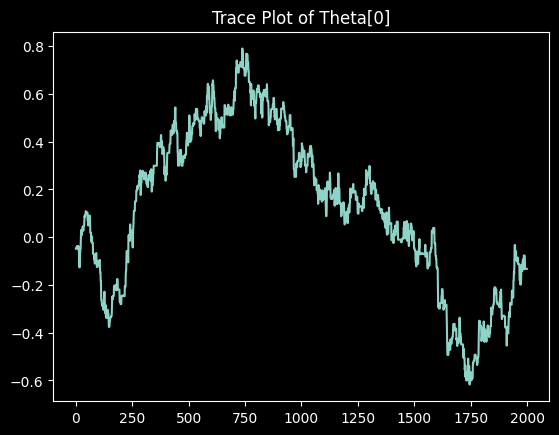

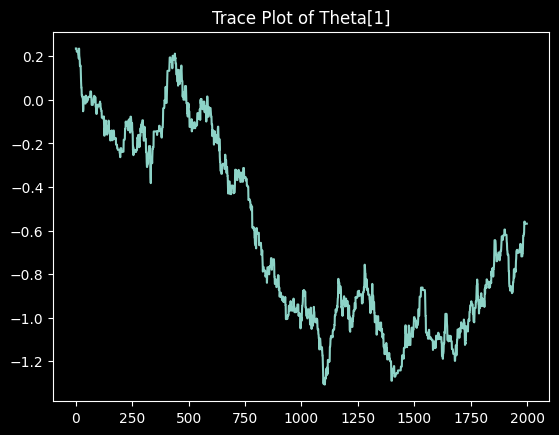

v_samples_test shape: (100, 200)


Time taken for generating virtual samples using rff, test 
0.0050 seconds

Time taken for computing prediction 
0.0099 seconds

Numerical method starts...
Time taken for numerically computing posterior mean and std 
0.1349 seconds

Analytical method starts...
Time taken for analytically computing posterior mean and std 
0.0050 seconds

Plotting...


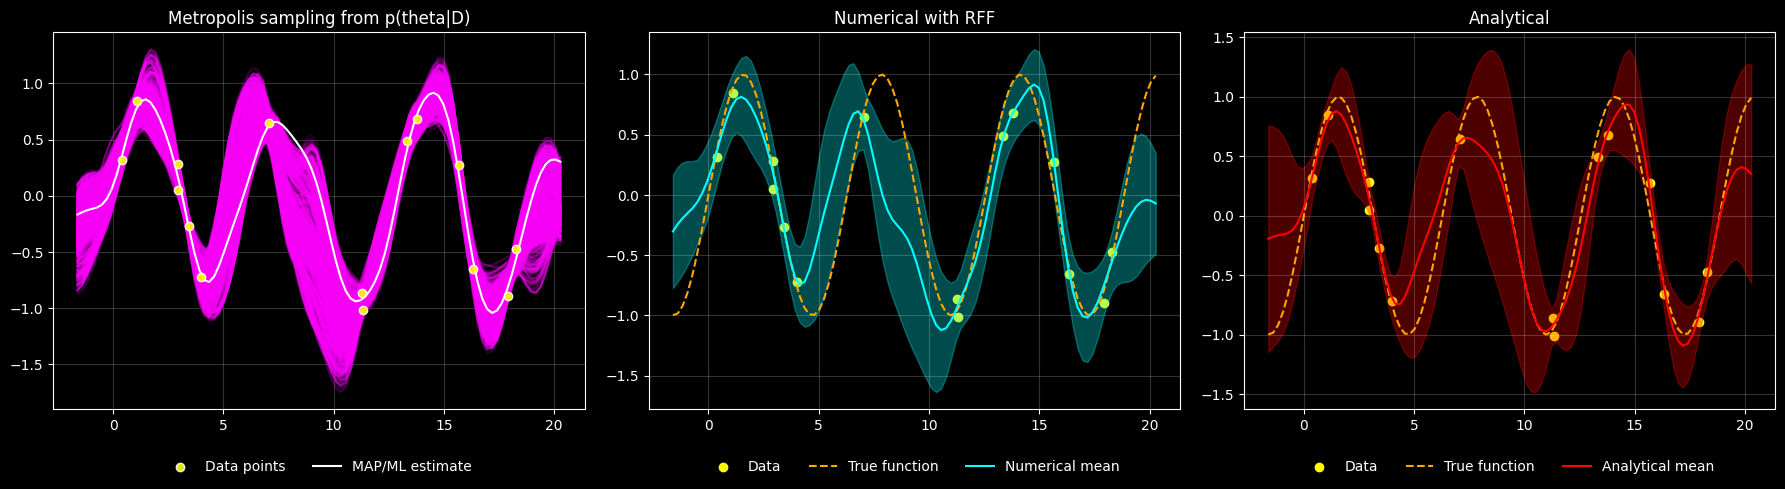

Time taken for plotting 
3.9268 seconds


In [ ]:
kernel_reg = BayesianKernelRegression(
    num_points=15,
    num_x_test=100,
    num_rff_features=200,
    num_mc=10,
    metropolis_step_size=1e-3,
    num_samples_metropolis=2000,
    burn_in=500,
    num_gd_iter=10000,
    debug=True
    )

kernel_reg.main_fit()

From the results, we can notice a few issues

* Prediction mean deviates more noticeably from analytical result. Potential reason can be that, due to high-dimensionality of RFF features, our model $y=\phi(x)^T\theta$ becomes `underdetermined` and we need to be more careful when trying to find optimal parameters
* Uncertainty in prediction directly now follows pattern of Metropolis results, since no variance correction step is needed, what we see from Metropolis is what we would get in the end. However, we also noticed that the descrepency between numerical and analytical results become more obvious

We will see what we can do with these in future notebooks....